In [1]:
from qiskit.quantum_info import Operator
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
import numpy as np
import sys

In [2]:
def myGrover(list_of_marked_elements):
    
    # Create list encoding the qubits on which X gates need to be applied for implementing the oracle

    n=len(list_of_marked_elements[0])
    
    l=[]
    for i in range(n):
        if list_of_marked_elements[0][i] == '0':
            l.append(n-1-i)
 
    list_oracle_qubits=[l] # list containing indices associated with 0 entries of marked elements 

    for i in range(1,len(list_of_marked_elements)):
        el=list_of_marked_elements[i]
        if len(el) != n:
            print('ERROR: all marked elements must have the same length')
            sys.exit(1)
        else:
            l=[]
            for i in range(n):
                if el[i] == '0':
                     l.append(n-1-i)
            
            union = list(set(l)|set(list_oracle_qubits[-1]))
            intersec = [value for value in l if value in list_oracle_qubits[-1]]
            list_oracle_qubits.append([value for value in union if value not in intersec])
    lf=[]
    for i in range(n):
        if list_of_marked_elements[-1][i] == '0':
            lf.append(n-1-i)
    
    print(list_oracle_qubits)
    # Create a quantum circuit on n qubits + n-2 ancilla qubits

    qr=QuantumRegister(n)
    anc=QuantumRegister(n-2)
    cl=ClassicalRegister(n)
    qc = QuantumCircuit(qr,anc,cl)

    
    # Determine r
    r = int(np.floor(np.pi/4*np.sqrt(2**n/len(list_of_marked_elements))))
    print(f'{n} qubits, basis states {list_of_marked_elements} marked, {r} rounds')
    
    # step 1: apply Hadamard gates on all qubits
    qc.h(range(n))
    qc.barrier()
    # step 2: apply r rounds of the phase oracle and the diffuser
    for _ in range(r):

        # Oracle

        for l in list_oracle_qubits:
            for el in l:
                qc.x(el)
            qc.barrier()
            qc.ccx(0,1,n)
            for i in range(n-3):
                qc.ccx(i+2,n+i,n+i+1)
            qc.cz(2*n-3,n-1)
            for i in range(n-4,-1,-1):
                qc.ccx(i+2,n+i,n+i+1)
            qc.ccx(0,1,n)
            qc.barrier()
        
        for i in lf:
            qc.x(i)
        qc.barrier()
        # Diffusion

        qc.h(range(n))
        
        qc.x(range(n))
        qc.ccx(0,1,n)
        for i in range(n-3):
            qc.ccx(i+2,n+i,n+i+1)
        qc.cz(2*n-3,n-1)
        for i in range(n-4,-1,-1):
            qc.ccx(i+2,n+i,n+i+1)
        qc.ccx(0,1,n)
        qc.barrier()
        qc.x(range(n))
        qc.h(range(n))
        qc.barrier()

        
    # step 3: measure all qubits
    qc.measure(range(n), range(n))
  
    return qc



[[4, 2, 0], [0, 1, 3, 5]]
6 qubits, basis states ['101010', '000001'] marked, 4 rounds


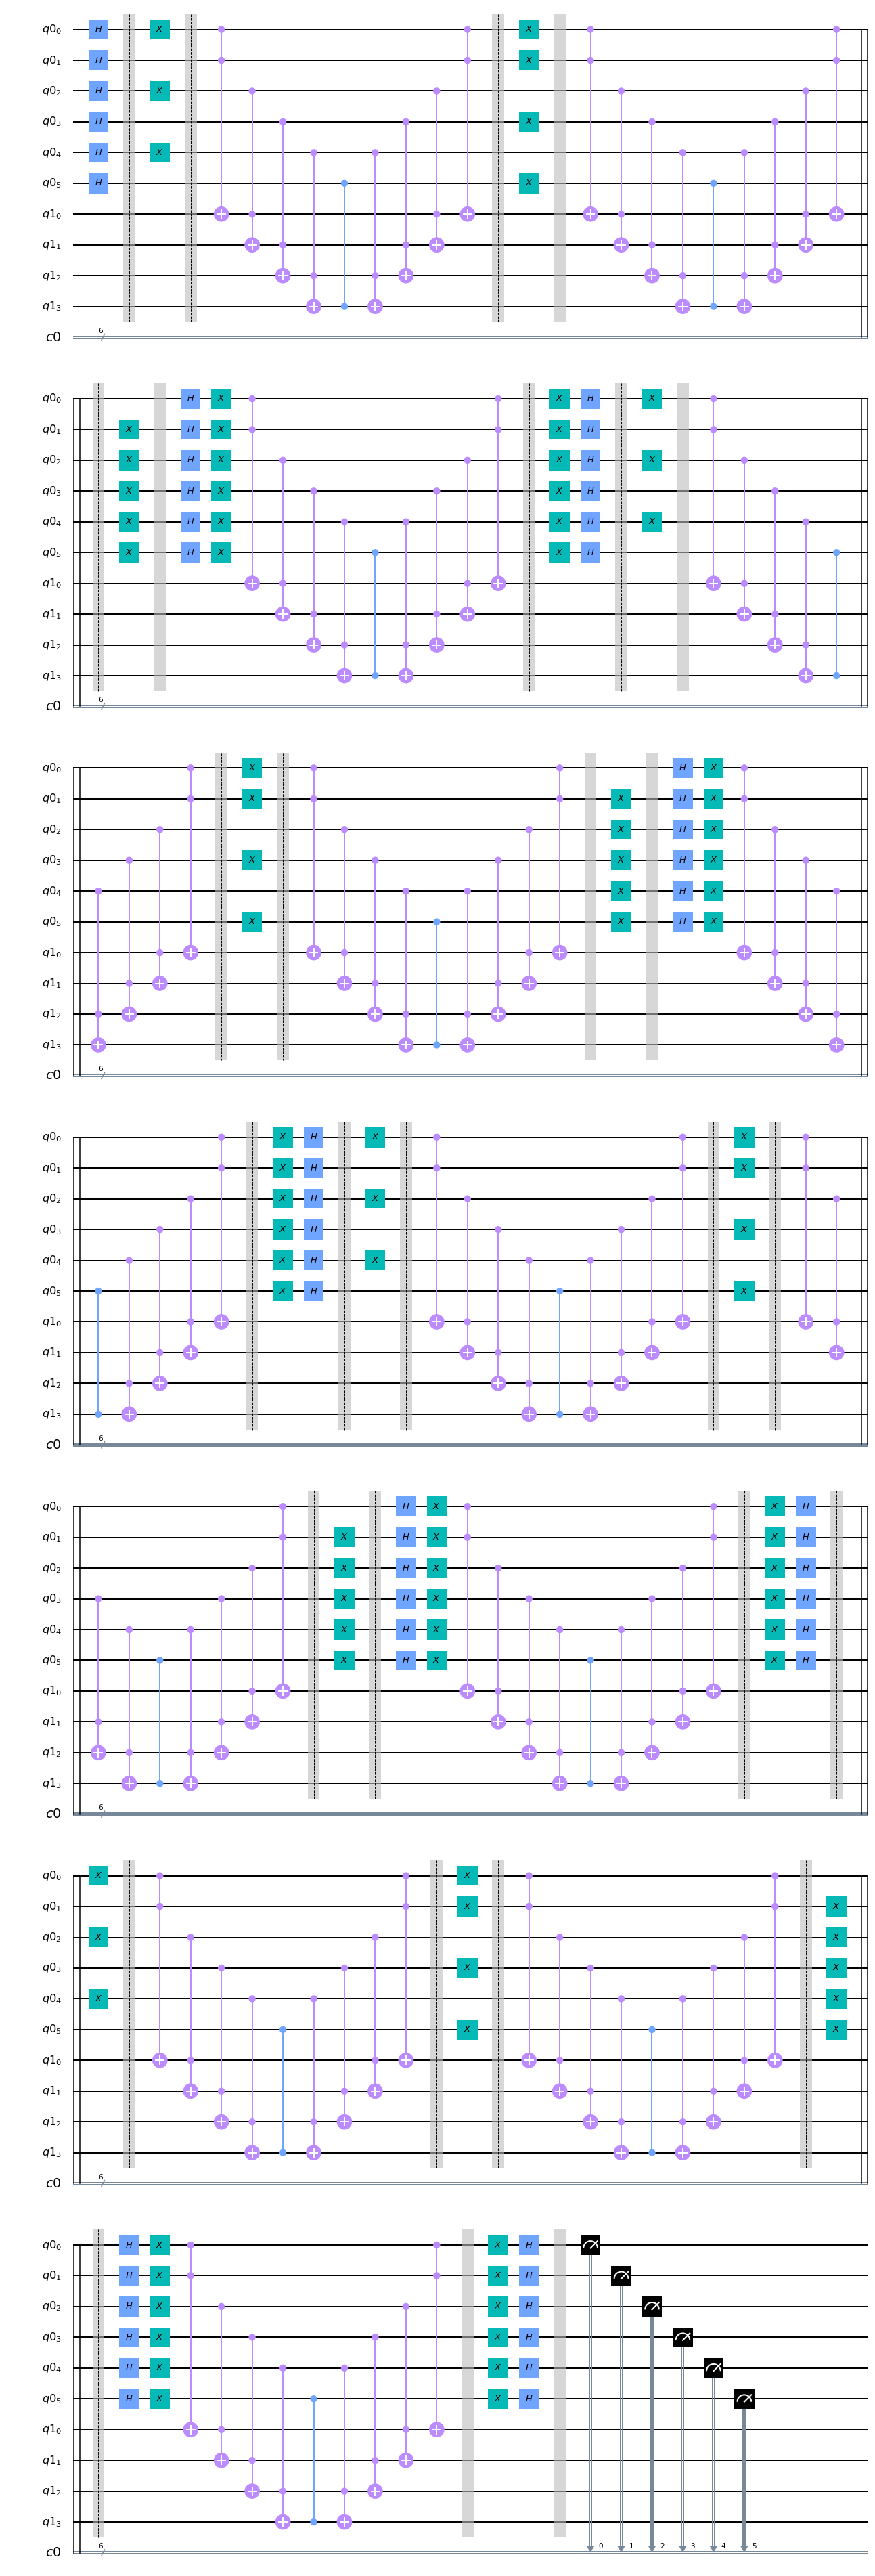

In [3]:
myCircuit = myGrover(['101010', '000001'])
myCircuit.draw(output='mpl')

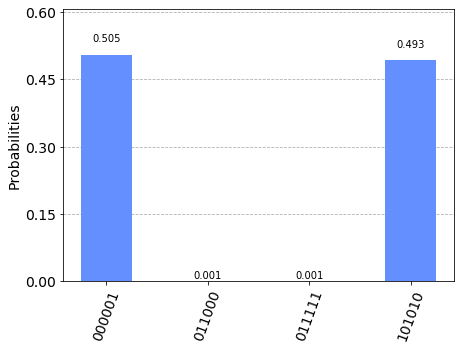

In [4]:
from qiskit import Aer, execute
simulator = Aer.get_backend('qasm_simulator')
counts = execute(myCircuit, backend=simulator, shots=1000).result().get_counts(myCircuit)
from qiskit.visualization import plot_histogram
plot_histogram(counts)